# **Install and import of necessary libraries:**

In [ ]:
# installing necessary libraries that are not already installed by default on Google Colab:

# library to read .ods files:
!pip install odfpy;
print('')
print('===============')
print('')

# library to read datasets directly from Google Big Query:
!pip install basedosdados;
#!pip install google-resumable-media
#!pip install --upgrade googleapis-common-protos
print('')
print('===============')
print('')

# library to make more advanced data visualizations:
!pip install plotly_express;

In [ ]:
# importing libraries:

# basic libraries:
import numpy as np
import pandas as pd

# data import libraries:
import basedosdados as bd
from google.colab import drive
import glob

# data visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px # bubble chart

# **Declaration of functions:**

In [ ]:
def gera_df_pop(drive_path):

    df_municipio = pd.read_excel(f'{drive_path}/datasets/planilhas_municipios/RELATORIO_DTB_BRASIL_MUNICIPIO.ods')

    df_populacao = pd.read_csv(f'{drive_path}/datasets/planilhas_populacao/populacao.csv')

    df = pd.merge(left=df_populacao, right=df_municipio, how='inner', left_on='id_municipio', right_on='Código Município Completo')

    cols = [
        'ano', 'id_municipio', 'Nome_Município', 'Nome_UF',
        'Nome Região Geográfica Intermediária', 'Nome Região Geográfica Imediata', 'Nome_Mesorregião', 'Nome_Microrregião',
        'sexo', 'grupo_idade', 'populacao'
    ]
    df = df[cols]

    df.columns = [
        'ano', 'id_municipio', 'nome_municipio', 'uf',
        'regiao_intermediaria', 'regiao_imediata', 'mesorregiao', 'microrregiao',
        'genero', 'grupo_idade', 'populacao'
    ]

    return df

def consolida_populacao_por_municipio(drive_path):

    df = gera_df_pop(drive_path)

    group_cols = ['ano', 'id_municipio', 'uf', 'regiao_intermediaria', 'regiao_imediata', 'mesorregiao', 'microrregiao', 'nome_municipio']

    df_group = df.groupby(by=group_cols, as_index=False).agg({
        'populacao': ['count', 'sum', 'mean', 'median', 'std']
    })

    df_group.columns = df_group.columns.droplevel(0)
    group_cols.extend(['qtde', 'pop_total', 'pop_media', 'pop_mediana', 'pop_std'])
    df_group.columns = group_cols

    return df_group


###############################

def gera_df_beneficiarios(file_path):

    df_beneficiarios = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')
    df_beneficiarios['CD_MUNICIPIO'] = df_beneficiarios['CD_MUNICIPIO'].astype(str)

    return df_beneficiarios


def consolida_beneficiarios_por_municipio(file_path):

    df = gera_df_beneficiarios(file_path)

    df_group = df.groupby(by=['CD_MUNICIPIO'], as_index=False).agg({
        'CD_OPERADORA': ['count', 'nunique'],
        'DT_INCLUSAO': ['nunique', 'min', 'max']
    })

    df_group.columns = df_group.columns.droplevel(0)
    df_group.columns = ['id_municipio', 'qtde_beneficiarios', 'qtde_operadoras', 'qtde_datas', 'min_data', 'max_data']
    df_group['file_path'] = file_path

    return df_group

def junta_beneficiarios_todos_estados(drive_path):

    all_files = glob.glob(f'{drive_path}/SIB/sib_202203_R*.csv')

    df = pd.concat((consolida_beneficiarios_por_municipio(file_path) for file_path in all_files))

    return df

###############################

def gera_df_estabelecimentos(drive_path):

    df_estabelecimentos = pd.read_csv(f'{drive_path}/CNES/bq-results-20220702-123105-1656765097865.csv')
    df_estabelecimentos['id_municipio_6'] = df_estabelecimentos['id_municipio_6'].astype(str)

    return df_estabelecimentos


def consolida_estabelecimentos_por_municipio(drive_path):

    df = gera_df_estabelecimentos(drive_path)

    df_group = df.groupby(by=['id_municipio_6'], as_index=False).agg({
        'id_cnes': ['count'],
        'tipo_unidade': ['nunique']
    })
    df_group.columns = df_group.columns.droplevel(0)
    df_group.columns = ['id_municipio', 'qtde_estabelecimentos', 'qtde_tipos']

    return df_group



###############################

def junta_datasets(df_pop, df_beneficiarios, df_estabelecimentos):

    df_pop = df_pop.query("ano == 2021")

    # pegando apenas os 6 primeiros digitos do id, pra poder cruzar com os outros datasets:
    df_pop['id_municipio'] = df_pop['id_municipio'].apply(lambda x: str(x)[0:6])

    df_merge = pd.merge(left=df_pop, right=df_beneficiarios, how='left', on='id_municipio')

    df_final = pd.merge(left=df_merge, right=df_estabelecimentos, how='left', on='id_municipio')


    df_final['proporcao_beneficiarios'] = df_final['qtde_beneficiarios'] / df_final['pop_total'] * 100
    df_final['cidadao_por_hospital'] = df_final['pop_total'] / df_final['qtde_estabelecimentos']
    df_final['beneficiario_por_hospital'] = df_final['qtde_beneficiarios'] / df_final['qtde_estabelecimentos']

    cols = [
        'id_municipio', 'uf', 'nome_municipio', 'regiao_intermediaria', 'regiao_imediata', 'mesorregiao', 'microrregiao',
        'pop_total', 'qtde_beneficiarios', 'qtde_operadoras', 'proporcao_beneficiarios',
        'qtde_estabelecimentos', 'cidadao_por_hospital', 'beneficiario_por_hospital'
    ]
    df_final = df_final[cols]

    return df_final


def monta_abt(drive_path):

    df_pop = consolida_populacao_por_municipio(drive_path)
    df_beneficiarios = junta_beneficiarios_todos_estados(drive_path)
    df_estabelecimentos = consolida_estabelecimentos_por_municipio(drive_path)

    df = junta_datasets(df_pop, df_beneficiarios, df_estabelecimentos)

    return df

# **Initial setup:**

In [ ]:
# connecting to my Google Drive:
drive.mount('/gdrive')

drive_path = '/gdrive/.shortcut-targets-by-id/1MNI7W_hrAxnm_EKmmeJI9LKcTUIegu2U/ASN.ROCKS'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
df = monta_abt(drive_path)

# **Exploratory Data Analysis (EDA):**

In [ ]:
df.shape

(5570, 14)

In [ ]:
df.head()

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,proporcao_beneficiarios,qtde_estabelecimentos,cidadao_por_hospital,beneficiario_por_hospital
0,110001,Rondônia,Alta Floresta D'Oeste,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,22516,1931.0,74.0,8.576124,36,625.444444,53.638889
1,110002,Rondônia,Ariquemes,Porto Velho,Ariquemes,Leste Rondoniense,Ariquemes,111148,12692.0,102.0,11.419009,151,736.079470,84.052980
2,110003,Rondônia,Cabixi,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,5067,267.0,21.0,5.269390,11,460.636364,24.272727
3,110004,Rondônia,Cacoal,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,86416,13979.0,102.0,16.176403,395,218.774684,35.389873
4,110005,Rondônia,Cerejeiras,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,16088,1238.0,43.0,7.695177,25,643.520000,49.520000


In [ ]:
df = df[df['qtde_beneficiarios'].notna()]
df.shape

(823, 14)

In [ ]:
df['qtde_beneficiarios'] = df['qtde_beneficiarios'].astype(int)
df['qtde_operadoras'] = df['qtde_operadoras'].astype(int)
df['proporcao_beneficiarios'] = df['proporcao_beneficiarios'].apply(lambda x: np.round(x, 2))
df['cidadao_por_hospital'] = df['cidadao_por_hospital'].astype(int)
df['beneficiario_por_hospital'] = df['beneficiario_por_hospital'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 823 entries, 0 to 5102
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_municipio               823 non-null    object 
 1   uf                         823 non-null    object 
 2   nome_municipio             823 non-null    object 
 3   regiao_intermediaria       823 non-null    object 
 4   regiao_imediata            823 non-null    object 
 5   mesorregiao                823 non-null    object 
 6   microrregiao               823 non-null    object 
 7   pop_total                  823 non-null    int64  
 8   qtde_beneficiarios         823 non-null    int64  
 9   qtde_operadoras            823 non-null    int64  
 10  proporcao_beneficiarios    823 non-null    float64
 11  qtde_estabelecimentos      823 non-null    int64  
 12  cidadao_por_hospital       823 non-null    int64  
 13  beneficiario_por_hospital  823 non-null    int64 

In [ ]:
df.head()

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,proporcao_beneficiarios,qtde_estabelecimentos,cidadao_por_hospital,beneficiario_por_hospital
450,210005,Maranhão,Açailândia,Imperatriz,Açailândia,Oeste Maranhense,Imperatriz,113783,16538,112,14.53,105,1083,157
451,210010,Maranhão,Afonso Cunha,Caxias,Caxias,Leste Maranhense,Coelho Neto,6631,176,13,2.65,9,736,19
452,210015,Maranhão,Água Doce do Maranhão,São Luís,Tutóia - Araioses,Leste Maranhense,Baixo Parnaíba Maranhense,12731,41,14,0.32,9,1414,4
453,210020,Maranhão,Alcântara,São Luís,São Luís,Norte Maranhense,Litoral Ocidental Maranhense,22126,159,19,0.72,20,1106,7
454,210030,Maranhão,Aldeias Altas,Caxias,Caxias,Leste Maranhense,Coelho Neto,26979,828,26,3.07,16,1686,51


In [ ]:
df.describe(exclude='object')

,pop_total,qtde_beneficiarios,qtde_operadoras,proporcao_beneficiarios,qtde_estabelecimentos,cidadao_por_hospital,beneficiario_por_hospital
count,1.290000e+03,1.290000e+03,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000
mean,2.710977e+04,8.146046e+03,45.126357,13.001008,51.537984,790.623256,82.310853
std,9.501359e+04,6.148568e+04,43.654032,14.916313,211.153797,424.877847,103.078526
min,7.710000e+02,8.000000e+00,3.000000,0.080000,1.000000,163.000000,0.000000
25%,5.448500e+03,1.912500e+02,20.000000,2.590000,8.000000,491.250000,19.000000
50%,1.088600e+04,6.015000e+02,31.000000,7.695000,14.000000,692.500000,47.000000
75%,2.156975e+04,2.455750e+03,54.000000,17.445000,29.000000,976.250000,102.750000
max,2.530701e+06,1.911202e+06,480.000000,124.090000,5631.000000,3685.000000,833.000000


In [ ]:
df.describe(include='object')

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao
count,1290,1290,1290,1290,1290,1290,1290
unique,1290,4,1286,26,122,26,120
top,316900,Minas Gerais,Água Boa,Juíz de Fora,Pouso Alegre,Sul/Sudoeste de Minas,Juiz de Fora
freq,1,853,2,146,34,146,33


In [ ]:
df['uf'].value_counts(dropna=False)

Minas Gerais          853
Maranhão              217
Mato Grosso           141
Mato Grosso do Sul     79
Name: uf, dtype: int64

In [ ]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.9)

In [ ]:
df_group = df.groupby(by=['regiao_intermediaria'], as_index=False).agg({
    'id_municipio': ['nunique'],
    'pop_total': ['sum'],
    'qtde_beneficiarios': ['sum'],,
    'proporcao_beneficiarios': ['mean', 'std', 'min', q25, 'median', q75, q90, 'max']
})

df_group.columns = df_group.columns.droplevel(0)
df_group.columns = [
    'regiao_intermediaria', 'qtde_municipios', 'soma_pop', 'soma_beneficiarios',
    'mean_prop', 'std_prop', 'min_prop', 'q25_prop', 'median_prop', 'q75_prop', 'q90_prop', 'max_prop'
]
df_group['prop_total'] = df_group['soma_beneficiarios'] / df_group['soma_pop'] * 100
df_group['prop_total'] = df_group['prop_total'].apply(lambda x: np.round(x, 2))

df_group.sort_values(by='prop_total', ascending=True)

,regiao_intermediaria,qtde_municipios,soma_pop,soma_beneficiarios,mean_prop,std_prop,min_prop,q25_prop,median_prop,q75_prop,q90_prop,max_prop,prop_total
15,Rorainópolis - Caracaraí,6,93978,660,0.636667,0.355678,0.20,0.3375,0.670,0.9500,1.005,1.01,0.70
0,Boa Vista,9,558735,42532,1.588889,3.011833,0.24,0.3800,0.430,0.8400,3.032,9.56,7.61
1,Caicó,24,300967,25840,5.685417,6.857506,1.50,2.5675,3.470,5.0750,12.999,33.05,8.59
5,Ji-Paraná,34,783830,87516,6.447941,4.461270,1.17,3.3600,4.850,8.4325,13.104,18.03,11.17
18,Uruguaiana,10,449870,50290,8.024000,5.862097,0.85,3.5425,6.900,11.6100,16.555,16.60,11.18
17,Santa Maria,40,765484,101647,6.003250,4.963931,1.10,2.1300,4.855,7.5050,13.754,23.39,13.28
9,Passo Fundo,144,1286594,198547,7.670972,6.334176,0.88,3.4675,5.495,9.3100,16.018,34.02,15.43
7,Mossoró,68,993286,159961,4.116618,5.969156,0.59,1.7075,2.315,3.3675,7.803,40.50,16.10
4,Ijuí,77,752951,133723,11.351299,9.115117,0.93,4.0500,9.810,16.0600,20.960,55.69,17.76
13,Porto Velho,18,1031448,186179,5.747778,6.568832,1.06,2.4150,3.045,6.2700,12.161,28.15,18.05


In [ ]:
df_bh = df.query("regiao_intermediaria == 'Belo Horizonte' ")
df_bh.head()

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,proporcao_beneficiarios,qtde_estabelecimentos,cidadao_por_hospital,beneficiario_por_hospital


In [ ]:
df_bh['proporcao_beneficiarios'].describe()

count    74.000000
mean     30.350405
std      21.575717
min       2.240000
25%      10.157500
50%      30.330000
75%      45.855000
max      91.850000
Name: proporcao_beneficiarios, dtype: float64

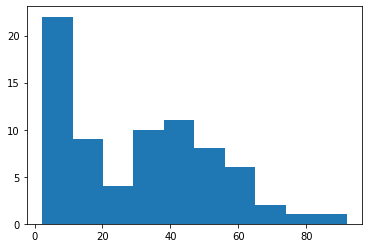

In [ ]:
plt.hist(df_bh['proporcao_beneficiarios']);

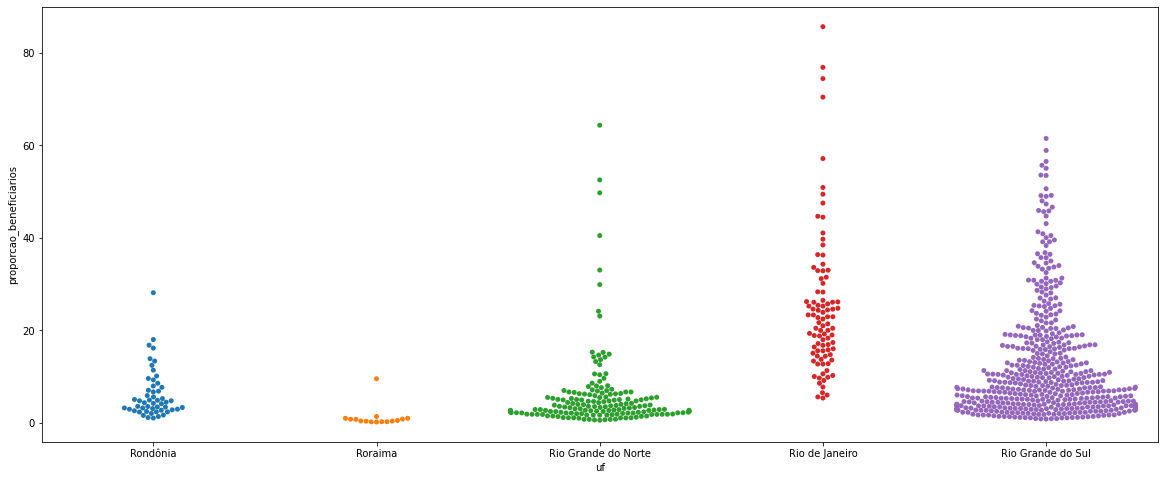

In [ ]:
plt.figure(figsize=(20,8))
sns.swarmplot(data=df, y='proporcao_beneficiarios', x='uf');
plt.show()

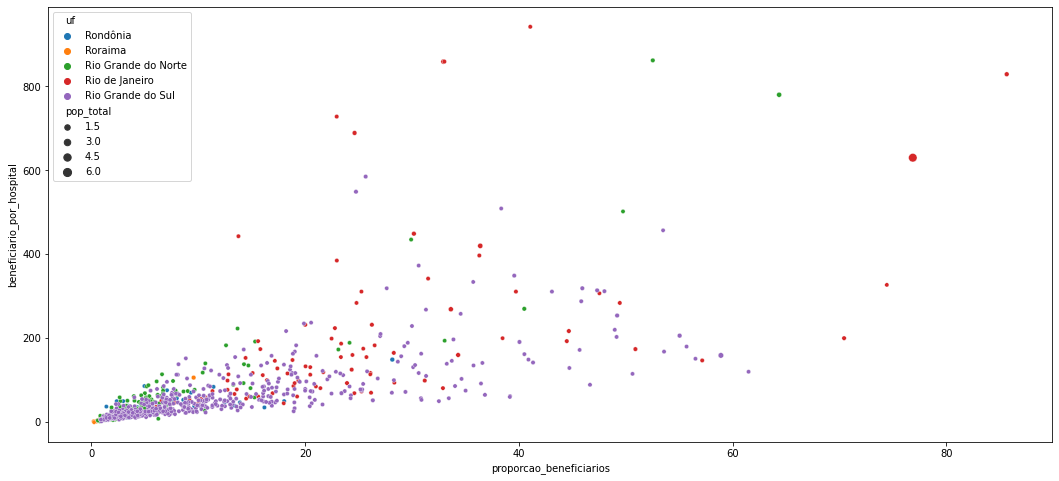

In [ ]:
plt.figure(figsize=(18,8))
sns.scatterplot(df['proporcao_beneficiarios'], df['beneficiario_por_hospital'], size=df['pop_total'], hue=df['uf']);
plt.show()

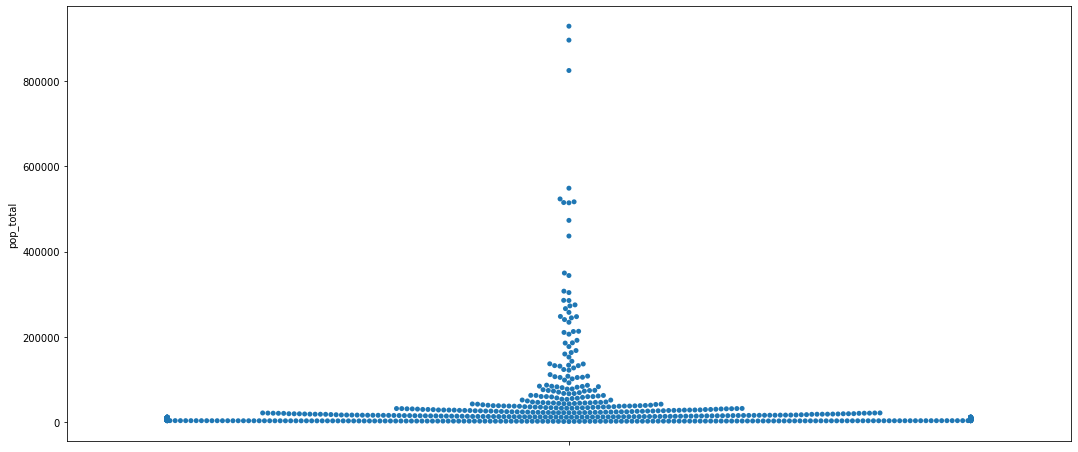

In [ ]:
plt.figure(figsize=(18,8))
sns.swarmplot(data=df.query("pop_total < 1000000"), y='pop_total'); #, x='mesorregiao');
plt.show()

In [ ]:
px.scatter(
    df, x='qtde_operadoras', y='proporcao_beneficiarios', opacity=0.8,
    size='beneficiario_por_hospital', color='uf', hover_name='nome_municipio',
    title='Situação dos Municípios de M* em 2021',
    log_x=False , color_discrete_sequence=px.colors.qualitative.Dark24,
    #,size_max=60 , range_x=[0, 50], range_y=[25,41]
    labels=dict(
        proporcao_beneficiarios='Beneficiários (%)',
        uf='Estado',
        regiao_intermediaria='Região Intermediária',
        mesorregiao='Mesorregião',
        qtde_operadoras='Quantidade de operadoras',
        beneficiario_por_hospital='Nº beneficiários a cada 1 hospital'
    )
)